# Generating cophenetic correlations


In [5]:
import matplotlib.pyplot as plt
import os

from scipy.cluster import hierarchy
import scipy
import glob
from matplotlib.colors import ListedColormap

import seaborn as sns
import cycler

from scipy import stats
import math
import numpy as np
import sys

##Get average-linkage clustering from distance matrix
def get_linkage(file):
    labels = []
    labels_to_id = dict()
    condensed = []
    counter = 0
    matrix = []
    square_sort_mat = []
    all_labels = set()
    refs_to_dist = dict()
    for line in open(file, 'r'):
        if counter == 0:
            #print(line)
            spl = line.split('\t')
            if len(spl) > 2:
                if 'sour' in file:
                    items = len(spl)
                    for i in range(len(spl)):
                        labels_to_id[spl[i].rstrip()] = i
                        labels.append(spl[i].rstrip())
                else:
                    items = len(spl) - 1
            else:
                items = int(line.split('\t')[-1].rstrip())
            matrix = [[] for x in range(items)]
            counter += 1
            continue
        if "\t" in line:
            spl = line.split("\t");
        else:
            spl = line.split();
        if 'sour' not in file:
            labels_to_id[spl[0]] = len(labels)
            labels.append(spl[0])
        endpoints = range(1, counter)
        if 'sour' in file:
            endpoints = range(0, counter-1)
        for i in endpoints:
            if 'mash' in file:
                matrix[i-1].append(1 - float(spl[i]))
            elif 'fastani' in file:
                #print(spl[i])
                mult = 1.00
                if "NA" in spl[i]:
                    matrix[i-1].append(0);
                else:
                    matrix[i-1].append(min(float(spl[i])/100 * mult,1))
            else:
                if 'sour' in file:
                    matrix[i].append(float(spl[i]))
                else:
                    matrix[i-1].append(float(spl[i]))
        counter += 1

    square_sort_mat = np.zeros((len(matrix),len(matrix)))
    labels.sort()
    for (i,label) in enumerate(labels):
        for (j, label2) in enumerate(labels):
            id1 = labels_to_id[label]
            id2 = labels_to_id[label2]
            dist = 0
            if i == j:
                continue
            elif id2 - id1 - 1< len(matrix[id1]) and id2 - id1 - 1 >= 0:
                dist = 1 - matrix[id1][id2-id1-1]
            elif id1 - id2 - 1< len(matrix[id2]) and id1 - id2 - 1 >= 0:
                dist = 1 - matrix[id2][id1-id2-1]
            else:
                print(i,j,id1,id2, len(matrix), len(matrix[id1]), len(matrix[id2]))
                exit()
            square_sort_mat[i,j] = dist
            square_sort_mat[j,i] = dist


    condensed = scipy.spatial.distance.squareform(square_sort_mat)
    Z = hierarchy.linkage(condensed, 'average')
    return (condensed, Z)

In [6]:
#Pasolli et al. directories where the distance matrices for all methods are stored. 
dirs = ["../precomputed_results/25-50/"]

#anim, skani, skanirobust, sourmash, fastani, mash,
cors = [[], [], [], [],[],[],[]]
for d in dirs:
    anim_results = glob.glob(d + "/anim_*")
    for anim_result in anim_results:
        (anim_mat, _Z) = get_linkage(anim_result+'/ANIm_percentage_identity.tab')

        num = anim_result.split("_")[-1].rstrip()

        skani_res = d + "skani_"+ num + ".identity"
        skani_res_robust =  d + "skani-robust_"+ num + ".identity"
        fastani_res = d + "fastani_" + num + ".matrix"
        sourmash_res = d+  "sour_" + num
        sourmash_res_normal = d+  "sour-normal_" + num
        mash_res = d + "mash_" + num
        os.system(f'sed -i "s/\,/\\t/g" {sourmash_res}')
        os.system(f'sed -i "s/\,/\\t/g" {sourmash_res_normal}')
        res_files = [skani_res, skani_res_robust, sourmash_res, sourmash_res_normal, fastani_res, mash_res]
        #Calculate cophenetic correlation for the linkage clustering against anim's matrix
        for (i,file) in enumerate(res_files):
            (_, Z) = get_linkage(file)
            cor = scipy.cluster.hierarchy.cophenet(Z,anim_mat)[0]
            cors[i+1].append(cor)
if len(cors[0]) > 0:
    #Output csv file of cophenetic correlations
    f = open("cophen.txt",'w')
    f.write('anim,skani,skani_robust,sourmash max-containment,sourmash,fastani,mash')
    for i in range(len(cors[0])):
        f.write(f"{cors[0][i]},{cors[1][i]},{cors[2][i]},{cors[3][i]},{cors[4][i]},{cors[5][i]},{cors[6][i]}")
        f.write('\n')

# Box plot of cophenetic correlations

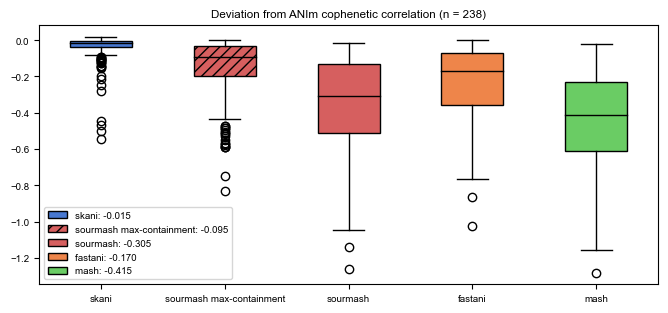

In [56]:
import matplotlib.pyplot as plt
import statistics

from matplotlib.colors import ListedColormap

import seaborn as sns
import cycler

from scipy import stats
import math
import numpy as np
import sys
import pandas as pd



cm = 1/2.54  # centimeters in inches

##Change this to get a bigger figure. 
fig = plt.figure(figsize=(17*cm, 8*cm))
cmap = sns.color_palette("muted")
plt.rcParams.update({'font.size': 7})
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.family':'arial'})

cph_file = 'cophen.txt'
counter = 0 
skani = []
skani_r = []
sour = []
sour_norm = []
fastani = []
mash = [] 
for line in open(cph_file,'r'):
    if counter == 0:
        counter += 1;
        continue

    val = line.split(',')
    anim = float(val[0])
    skani.append(float(val[1]) - anim)
    skani_r.append(float(val[2]) - anim)
    sour.append(float(val[3]) - anim)
    sour_norm.append(float(val[4]) - anim)
    fastani.append(float(val[5]) - anim)
    mash.append(float(val[6]) - anim)

data = [skani,sour,sour_norm,fastani,mash]
bplot = plt.boxplot(data, patch_artist = True)
#txt = f"skani: {bplot['medians'][0]}\n skani robust: {bplot['medians'][1]}\n sourmash max-containment: {bplot['medians'][2]}\n fastani: {bplot['medians'][3]}, mash: {bplot['medians'][4]}"
#bplot = plt.boxplot([skani,skani_r,sour,fastani,mash], patch_artist = True, label)
colors = [cmap[0], cmap[3], cmap[3],  cmap[1], cmap[2]]
i = 0
for patch, color in zip(bplot['boxes'], colors):
    if i == 1:
        patch.set(hatch = '///')
    patch.set_facecolor(color)
    i+=1


means = [statistics.mean(x) for x in data]
medians = [statistics.median(x) for x in data]

plt.legend([bplot["boxes"][0], bplot["boxes"][1],bplot["boxes"][2],bplot["boxes"][3],bplot["boxes"][4]], [f"skani: {medians[0]:.3f}", f'sourmash max-containment: {medians[1]:.3f}', f'sourmash: {medians[2]:.3f}', f'fastani: {medians[3]:.3f}',f'mash: {medians[4]:.3f}'], loc='lower left')
labels = ["skani", "sourmash max-containment", "sourmash", "fastani", "mash"]
for median in bplot['medians']:
    median.set_color('black')
plt.xticks(ticks = [1,2,3,4,5], labels = labels)
plt.title(f"Deviation from ANIm cophenetic correlation (n = {len(skani)})")
plt.savefig('figures/cophenetic_boxplot.svg', transparent = True)
plt.show()



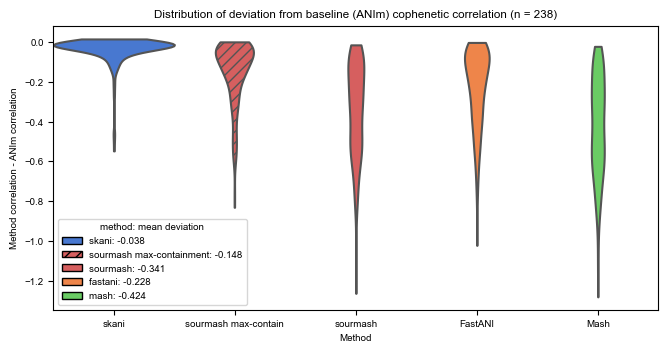

In [109]:
labels = ['skani' for x in range(len(skani))] + ['sourmash max-contain' for x in range(len(skani))] +['sourmash' for x in range(len(skani))]  + ['FastANI' for x in range(len(skani))]  + ['Mash' for x in range(len(skani))] 
df = pd.DataFrame(data = {'Method correlation - ANIm correlation':skani + sour + sour_norm + fastani + mash, 'Method':labels})
#print(df)

fig = plt.figure(figsize=(17*cm, 9*cm))
import matplotlib as mpl

vp = sns.violinplot(df, y='Method correlation - ANIm correlation', x = 'Method',palette = colors, 
                    width = 1.,cut=0,saturation=1,inner=None)
for i, bar in enumerate(vp.get_children()):
    #print(bar)
    if i ==1:
        bar.set_hatch('///')

plt.title(f"Distribution of deviation from baseline (ANIm) cophenetic correlation (n = {len(skani)})")
plt.legend([bplot["boxes"][0], bplot["boxes"][1],bplot["boxes"][2],bplot["boxes"][3],bplot["boxes"][4]], [f"skani: {means[0]:.3f}", f'sourmash max-containment: {means[1]:.3f}', f'sourmash: {means[2]:.3f}', f'fastani: {means[3]:.3f}',f'mash: {means[4]:.3f}'], title='method: mean deviation',  loc='lower left')
plt.savefig("figures/violin_cophenetic_cor.svg", transparent=True)
plt.show()